Project 3

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns

age_labels = ['0-2','3-9','10-19','20-29','30-39','40-49','50-59','60-69','more than 70']
gender_labels = ['Female','Male']
race_labels= ['East Asian', 'Indian', 'Black', 'White', 'Middle Eastern', 'Latino_Hispanic', 'Southeast Asian']
service_test_labels = ['True', 'False']
features = ['age','gender','race']
cat_labels = {
    'age': age_labels,
    'gender' : gender_labels,
    'race' : race_labels,
    # 'service_test' : service_test_labels
    }

training_path = 'fairface_label_train.csv'
validation_path = 'fairface_label_val.csv'


def one_hot_encode(df,feature,labels):
    cats = df[feature].values
    one_hot = np.zeros((cats.size,labels.__len__()))
    for i in range(cats.size):
        one_hot[i][labels.index(cats[i])] = 1
    return one_hot

def one_hot_decode(one_hot,labels):
    return [labels[np.argmax(one_hot[i])] for i in range(one_hot.shape[0])]

def read_images(n, path):
    # read in csv file
    df = pd.read_csv(path)
    # sample n rows
    df = df.sample(n, random_state=42)
    # reset index
    df = df.reset_index(drop=True)
    # create empty list for images
    images = np.zeros((n, 32, 32, 1), dtype=np.uint8)
    # loop through each row and read in image file        
    for index, row in df.iterrows():
        image_path = row["file"]
        image = Image.open(image_path)
        img = np.array(image)
        img = img.reshape(32,32,1)
        images[index] = img

    df = df.drop(columns=["file"])
    df['image_id'] = df.index   
    return df, images

def plot_images(df,images):
    # plot images
    fig, axs = plt.subplots(len(images)//5, 5, figsize=(20, 20))
    for i, ax in enumerate(axs.flat):
        ax.imshow(images[i])
        ax.axis('off')
        ax.set_title(df.loc[i, "age"] + ", " + df.loc[i, "gender"] + ", " + df.loc[i, "race"])
    plt.show()
    
def min_max_scale_images(images):
    # Min-max scale each image
    images_min_max = np.zeros(images.shape)
    iter=0
    for i in images:
        ama = np.amax(i)
        ami = np.amin(i)
        i = (i - ami) / (ama - ami)
        images_min_max[iter] = i
        iter+=1
    return images_min_max

def count_categories(path):
    df = pd.read_csv(path)
    for column in df.columns:
        print(f"{column}: {df[column].nunique()} categories")

def load_data(n, path,plot=False):
    df, images = read_images(n, path)
    images = min_max_scale_images(images)
    if plot:
        plot_images(df,images)
    
    
    # One-hot encode labels
    one_hot = {}
    labels = {}
    for feature in features:
        one_hot[feature] = one_hot_encode(df, feature, cat_labels[feature])
        labels[feature] = one_hot_decode(one_hot[feature], cat_labels[feature])
    
    return images, one_hot, labels

def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    # plot training and validation loss
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title('Model Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend(['train', 'val'], loc='best')

    # plot training and validation accuracy
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title('Model Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(['train', 'val'], loc='best')

    plt.show()
    
def evaluate_model(model, images_train, one_hot_train, labels_train, images_test, one_hot_test, labels_test, target):
    # Evaluate the model on test data
    test_loss, test_acc = model.evaluate(images_test, one_hot_test[target])

    # Get predictions for the test data
    test_pred_one_hot = model.predict(images_test)
    test_pred_labels = one_hot_decode(test_pred_one_hot, cat_labels[target])

    # Create the confusion matrix
    cm = confusion_matrix(labels_test[target], test_pred_labels, labels=cat_labels[target])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='viridis', fmt='g', xticklabels=cat_labels[target], yticklabels=cat_labels[target])
    plt.xlabel('Predicted labels')
    ax = plt.gca()
    ax.invert_yaxis()
    plt.ylabel('True labels')
    plt.title('Confusion matrix')
    plt.show()
    
    print('Final classification accuracy:', test_acc)


In [70]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, concatenate, Dropout
from tensorflow.keras.models import Model

def FullyConnectedNetwork(output_size):
    return Sequential([
            Flatten(input_shape=(32, 32, 1)),
            Dense(1024, activation='tanh'),
            Dense(512, activation='sigmoid'),
            Dense(100, activation='relu'),
            Dense(output_size, activation='softmax')
        ])
    
def SmallCNN(output_size):
    return Sequential([
            Conv2D(40,input_shape=(32,32,1),kernel_size=(5,5),strides=1,padding='valid', activation='relu'),
            MaxPooling2D(pool_size=(2,2)),
            Flatten(),
            Dense(100,activation='relu'),
            Dense(output_size,activation='softmax')
        ])
    
def CustomCNN(output_size):
    return Sequential([
        Conv2D(64, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation="relu", padding="same"),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation="relu", padding="same"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.5),
        Dense(output_size,activation='softmax')
    ])

def MultiTaskCNN(output_size, features):
    # Define inputs
    inputs = Input(shape=(32, 32, 1))

    # Convolutional layers for feature1 branch
    feature1_conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same',)(inputs)
    feature1_pool1 = MaxPooling2D(pool_size=(2, 2))(feature1_conv1)
    feature1_conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(feature1_pool1)
    feature1_pool2 = MaxPooling2D(pool_size=(2, 2))(feature1_conv2)

    # Convolutional layers for feature2 branch
    feature2_conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    feature2_pool1 = MaxPooling2D(pool_size=(2, 2))(feature2_conv1)
    feature2_conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(feature2_pool1)
    feature2_pool2 = MaxPooling2D(pool_size=(2, 2))(feature2_conv2)

    # Flatten and concatenate branches
    feature1_flatten = Flatten()(feature1_pool2)
    feature2_flatten = Flatten()(feature2_pool2)
    merged = concatenate([feature1_flatten, feature2_flatten])

    # Fully connected layers
    dense1 = Dense(128, activation='relu')(merged)
    feature1_dense2 = Dense(64, activation='relu')(dense1)
    feature1_output = Dense(output_size[0], activation='softmax', name=f'{features[0]}_output')(feature1_dense2)
    feature2_dense2 = Dense(64, activation='relu')(dense1)
    feature2_output = Dense(output_size[1], activation='softmax', name=f'{features[1]}_output')(feature2_dense2)

    return Model(inputs=inputs, outputs=[feature1_output, feature2_output])   


def do_task(target, model, ntrain, nval, loss, optimizer, epochs, batch_size, metrics):
    
    images_train, one_hot_train, labels_train = load_data(ntrain, training_path, plot=False)
    images_test, one_hot_test, labels_test = load_data(nval, validation_path, plot=False)
    
    # Create the model   
    output_size = len(cat_labels[target])
    if model == 'FullyConnectedNetwork':
        model = FullyConnectedNetwork(output_size)
    elif model == 'SmallCNN':
        model = SmallCNN(output_size)
    elif model == 'CustomCNN':
        model = CustomCNN(output_size)
        
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    model.summary()
    
    # Train the model
    history = model.fit(images_train, one_hot_train[target], epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    # Plot the training and validation loss and accuracy
    plot_history(history)
    
    # Evaluate the model on test data
    evaluate_model(model, images_train, one_hot_train, labels_train, images_test, one_hot_test, labels_test, target) 

def do_multi_task(targets, model, ntrain, nval, loss, optimizer, epochs, batch_size, metrics):
    
    images_train, one_hot_train, labels_train = load_data(ntrain, training_path, plot=False)
    images_test, one_hot_test, labels_test = load_data(nval, validation_path, plot=False)
    
    # Create the model   
    output_size = [len(cat_labels[target]) for target in targets]
    model = MultiTaskCNN(output_size, targets)       
    model.compile(optimizer=optimizer,
                  loss = {f'{targets[0]}_output': loss, f'{targets[1]}_output': loss},
                  metrics=metrics)
    model.summary()
    
    # Train the model
    history = model.fit(images_train, {f'{targets[0]}_output': one_hot_train[targets[0]], f'{targets[1]}_output': one_hot_train[targets[1]]},
        epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    # Plot the training and validation loss and accuracy
    plot_history(history)
    
    # # Evaluate the model on test data
    # evaluate_model(model, images_train, one_hot_train, labels_train, images_test, one_hot_test, labels_test, target) 

Preview Dataset

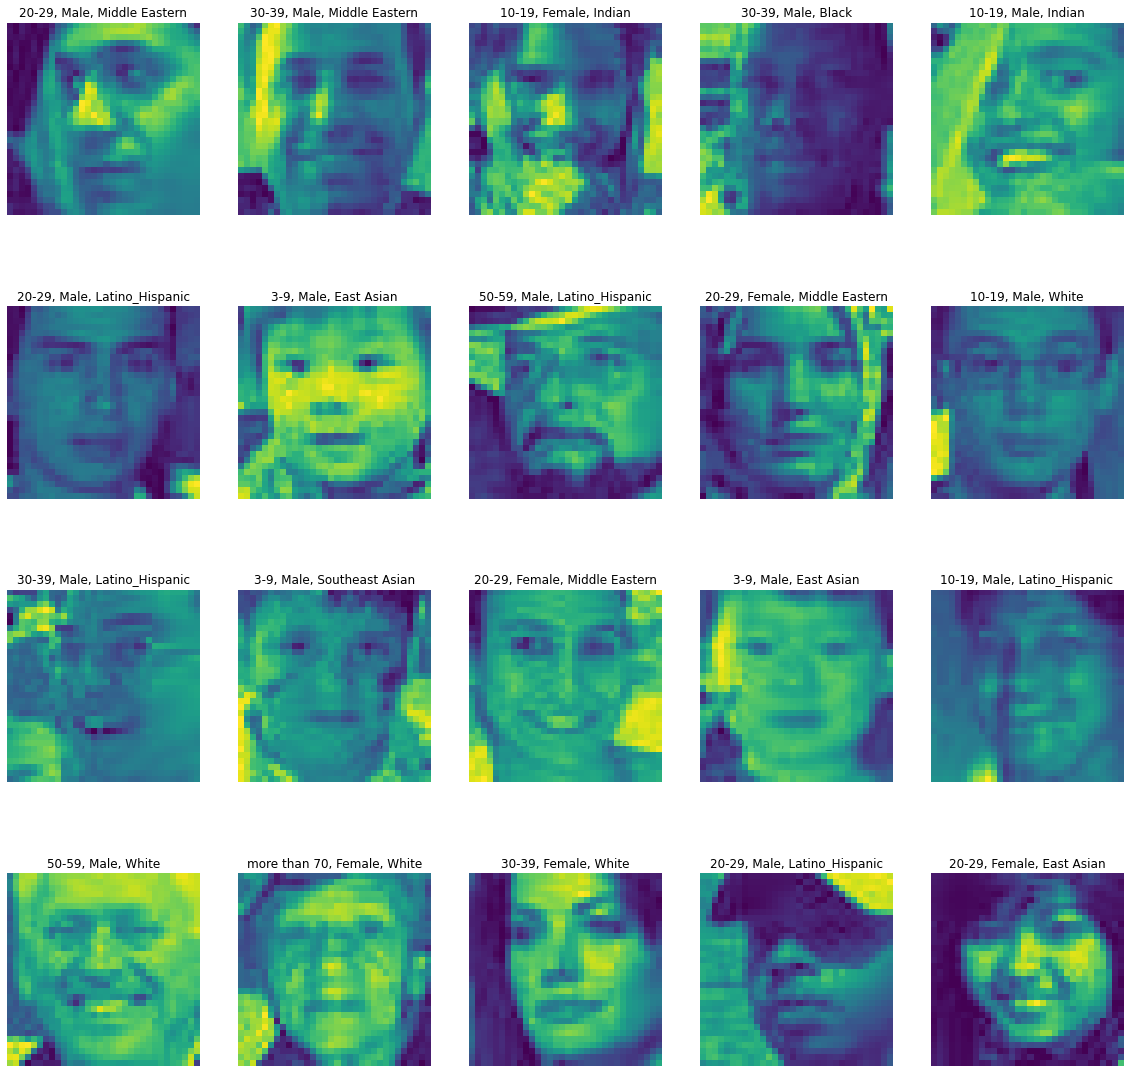

In [61]:
images_train, one_hot_train, labels_train = load_data(20, training_path, plot=True)

Task 1: Fully Connected Neural Network

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_21 (Flatten)        (None, 1024)              0         
                                                                 
 dense_66 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_67 (Dense)            (None, 512)               524800    
                                                                 
 dense_68 (Dense)            (None, 100)               51300     
                                                                 
 dense_69 (Dense)            (None, 9)                 909       
                                                                 
Total params: 1,626,609
Trainable params: 1,626,609
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3/3 [===========================

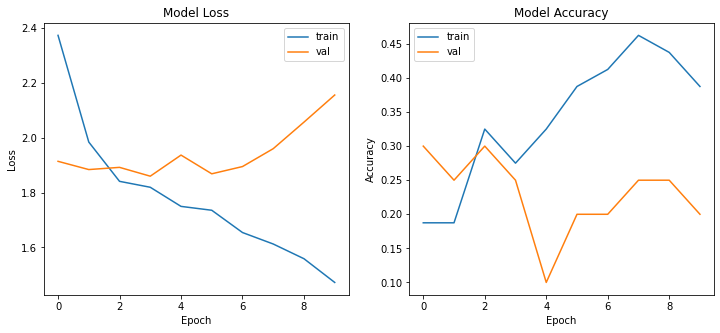

4/4 [==============================] - 0s 4ms/step


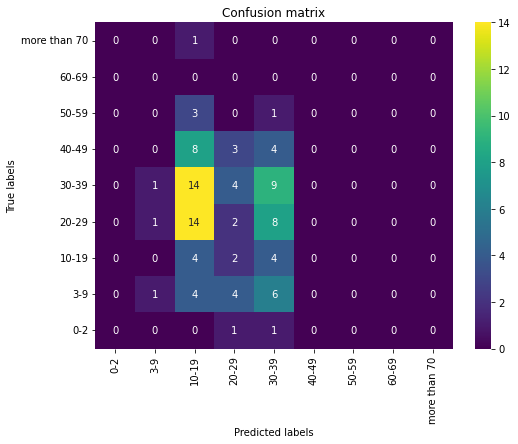

Final classification accuracy: 0.1599999964237213


In [62]:
do_task(target='age', model="FullyConnectedNetwork", ntrain=100, nval=100, loss='categorical_crossentropy', optimizer='adam', epochs=10, batch_size=32, metrics=['accuracy'])

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_22 (Flatten)        (None, 1024)              0         
                                                                 
 dense_70 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_71 (Dense)            (None, 512)               524800    
                                                                 
 dense_72 (Dense)            (None, 100)               51300     
                                                                 
 dense_73 (Dense)            (None, 2)                 202       
                                                                 
Total params: 1,625,902
Trainable params: 1,625,902
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3/3 [===========================

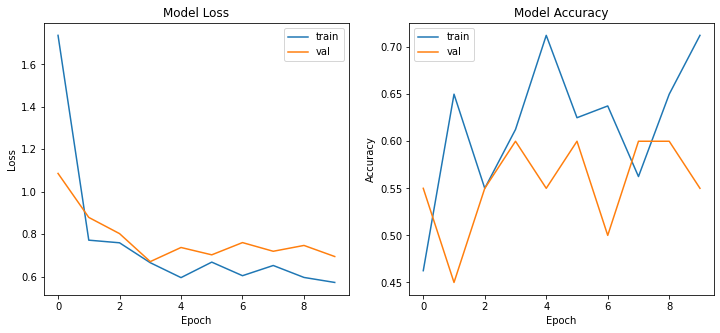

4/4 [==============================] - 0s 4ms/step


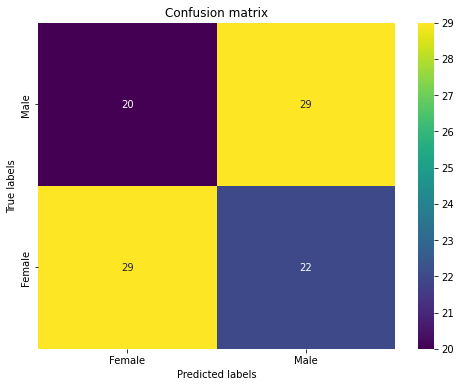

Final classification accuracy: 0.5799999833106995


In [63]:
do_task(target='gender', model="FullyConnectedNetwork", ntrain=100, nval=100, loss='categorical_crossentropy', optimizer='adam', epochs=10, batch_size=32, metrics=['accuracy'])

Task 2: Small Convolutional Neural Network

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 28, 28, 40)        1040      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 14, 14, 40)       0         
 g2D)                                                            
                                                                 
 flatten_23 (Flatten)        (None, 7840)              0         
                                                                 
 dense_74 (Dense)            (None, 100)               784100    
                                                                 
 dense_75 (Dense)            (None, 9)                 909       
                                                                 
Total params: 786,049
Trainable params: 786,049
Non-trainable params: 0
_______________________________________________

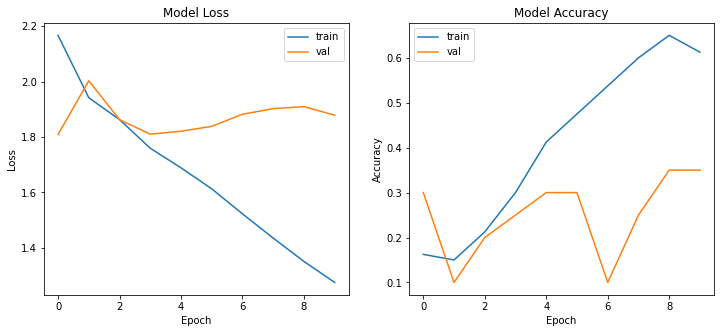

4/4 [==============================] - 0s 6ms/step


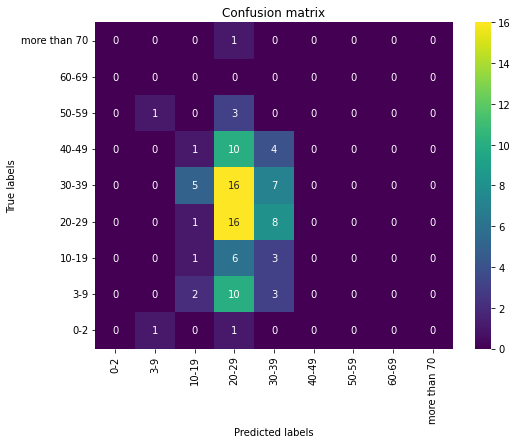

Final classification accuracy: 0.23999999463558197


In [64]:
do_task(target='age', model="SmallCNN", ntrain=100, nval=100, loss='categorical_crossentropy', optimizer='adam', epochs=10, batch_size=32, metrics=['accuracy'])

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 28, 28, 40)        1040      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 14, 14, 40)       0         
 g2D)                                                            
                                                                 
 flatten_24 (Flatten)        (None, 7840)              0         
                                                                 
 dense_76 (Dense)            (None, 100)               784100    
                                                                 
 dense_77 (Dense)            (None, 2)                 202       
                                                                 
Total params: 785,342
Trainable params: 785,342
Non-trainable params: 0
_______________________________________________

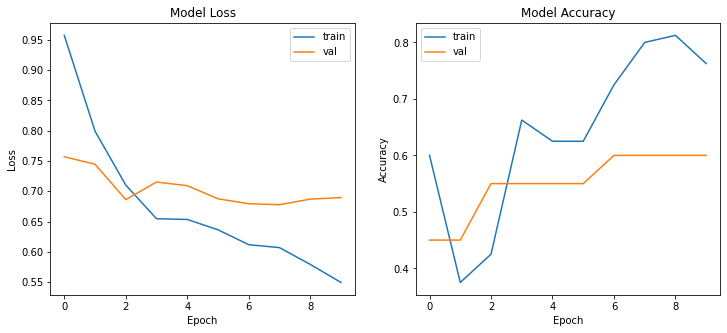

4/4 [==============================] - 0s 5ms/step


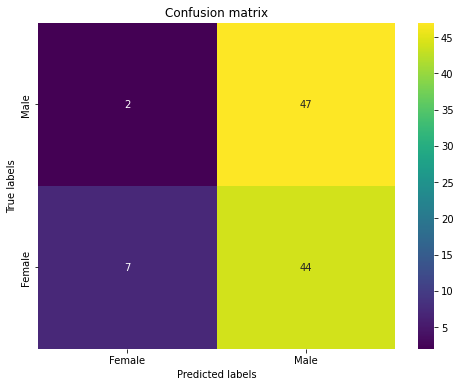

Final classification accuracy: 0.5400000214576721


In [65]:
do_task(target='gender', model="SmallCNN", ntrain=100, nval=100, loss='categorical_crossentropy', optimizer='adam', epochs=10, batch_size=32, metrics=['accuracy'])

Task 3: Your own Convolutional Neural Network

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 32, 32, 64)        640       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 4, 4, 256)      

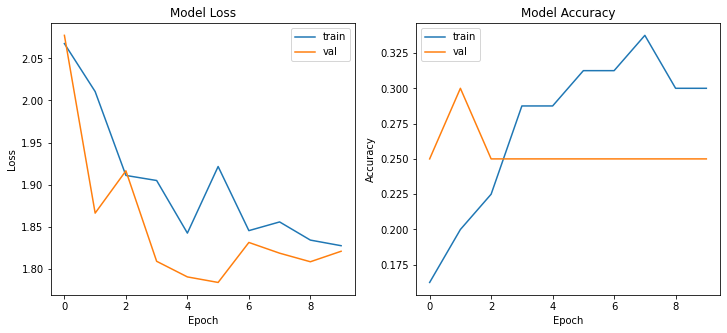

4/4 [==============================] - 0s 15ms/step


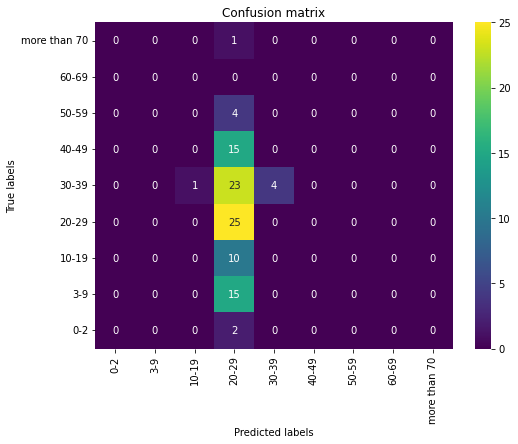

Final classification accuracy: 0.28999999165534973


In [66]:
do_task(target='age', model="CustomCNN", ntrain=100, nval=100, loss='categorical_crossentropy', optimizer='adam', epochs=10, batch_size=32, metrics=['accuracy'])

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 32, 32, 64)        640       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 4, 4, 256)      

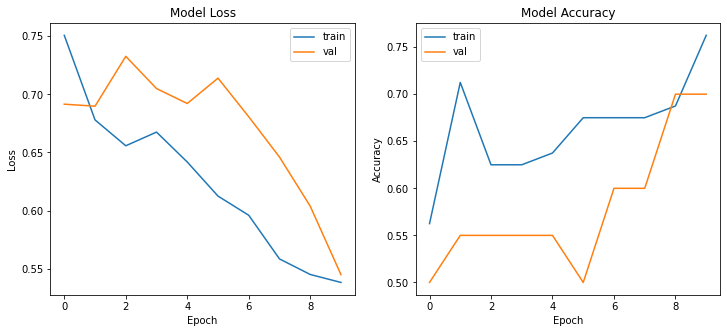

4/4 [==============================] - 0s 15ms/step


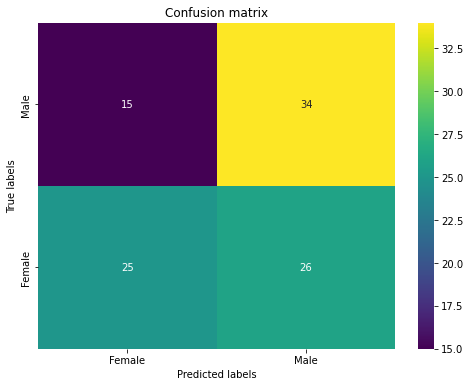

Final classification accuracy: 0.5899999737739563


In [67]:
do_task(target='gender', model="CustomCNN", ntrain=100, nval=100, loss='categorical_crossentropy', optimizer='adam', epochs=10, batch_size=32, metrics=['accuracy'])

Task 4: Your own Convolutional Neural Network on both Tasks Simultaneously

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_29 (Conv2D)             (None, 32, 32, 32)   320         ['input_2[0][0]']                
                                                                                                  
 conv2d_31 (Conv2D)             (None, 32, 32, 32)   320         ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_29 (MaxPooling2D  (None, 16, 16, 32)  0           ['conv2d_29[0][0]']              
 )                                                                                          

KeyError: 'accuracy'

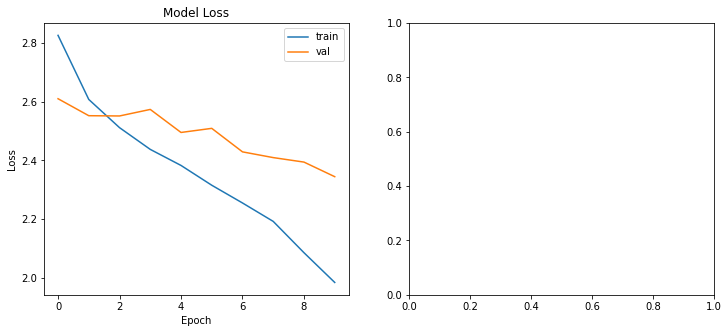

In [71]:
do_multi_task(targets=['age','gender'], model="MultiTaskCNN", ntrain=100, nval=100, loss='categorical_crossentropy', optimizer='adam', epochs=10, batch_size=32, metrics=['accuracy'])